# Overview

The remain of this notebook is organized as follow:
- Section 01 contains the cells responsible for testing the CNN model for CSI compression.
- Section 02 contains the cells responsible for training the CNN model for CSI compression. 

# Section 01

In [1]:
# Import necessary modules
import math
import time
import numpy as np
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, BatchNormalization, Reshape, Conv2D, add, LeakyReLU
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard, Callback
tf.compat.v1.reset_default_graph()

In [2]:
# Set image and network params
envir = 'indoor' #'indoor' or 'outdoor'

# Image params
img_height = 32
img_width = 32
img_channels = 2 
img_total = img_height*img_width*img_channels

# Network params
residual_num = 2
encoded_dim = 512  #compress rate=1/4->dim.=512, compress rate=1/16->dim.=128, compress rate=1/32->dim.=64, compress rate=1/64->dim.=32

In [3]:
# Load pre-trained model and weights
file = 'CsiNet_'+(envir)+'_dim'+str(encoded_dim)

# Load json and create model
outfile = "files_06_channel/saved_model/model_%s.json"%file
json_file = open(outfile, 'r')
loaded_model_json = json_file.read()
json_file.close()
autoencoder = model_from_json(loaded_model_json)

# Load weights outto new model
outfile = "files_06_channel/saved_model/model_%s.h5"%file
autoencoder.load_weights(outfile)

2022-09-08 15:01:35.712717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:01:35.732264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:01:35.732398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:01:35.732930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
# Load dataset
if envir == 'indoor':
  mat = sio.loadmat('files_06_channel/data/DATA_Htestin.mat')
  x_test = mat['HT'] # array

elif envir == 'outdoor':
  mat = sio.loadmat('files_06_channel/data/DATA_Htestout.mat')
  x_test = mat['HT'] # array

x_test = x_test.astype('float32')
x_test = np.reshape(x_test, (len(x_test), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format

In [5]:
# Testing data
tStart = time.time()
x_hat = autoencoder.predict(x_test)
tEnd = time.time()
print ("It cost %f sec" % ((tEnd - tStart)/x_test.shape[0]))

2022-09-08 15:01:50.329079: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


625/625 [==============================] - 5s 4ms/step
It cost 0.000251 sec


In [6]:
# Calcaulating the NMSE and rho

# Load data with 125 (subcarriers) * 32 (antenna) to calculate rho
if envir == 'indoor':
  mat = sio.loadmat('files_06_channel/data/DATA_HtestFin_all.mat')
  X_test = mat['HF_all']# array

elif envir == 'outdoor':
  mat = sio.loadmat('files_06_channel/data/DATA_HtestFout_all.mat')
  X_test = mat['HF_all']# array

X_test = np.reshape(X_test, (len(X_test), img_height, 125))
x_test_real = np.reshape(x_test[:, 0, :, :], (len(x_test), -1))
x_test_imag = np.reshape(x_test[:, 1, :, :], (len(x_test), -1))
x_test_C = x_test_real-0.5 + 1j*(x_test_imag-0.5)
x_hat_real = np.reshape(x_hat[:, 0, :, :], (len(x_hat), -1))
x_hat_imag = np.reshape(x_hat[:, 1, :, :], (len(x_hat), -1))
x_hat_C = x_hat_real-0.5 + 1j*(x_hat_imag-0.5)
x_hat_F = np.reshape(x_hat_C, (len(x_hat_C), img_height, img_width))
X_hat = np.fft.fft(np.concatenate((x_hat_F, np.zeros((len(x_hat_C), img_height, 257-img_width))), axis=2), axis=2)
X_hat = X_hat[:, :, 0:125]

n1 = np.sqrt(np.sum(np.conj(X_test)*X_test, axis=1))
n1 = n1.astype('float64')
n2 = np.sqrt(np.sum(np.conj(X_hat)*X_hat, axis=1))
n2 = n2.astype('float64')
aa = abs(np.sum(np.conj(X_test)*X_hat, axis=1))
rho = np.mean(aa/(n1*n2), axis=1)
X_hat = np.reshape(X_hat, (len(X_hat), -1))
X_test = np.reshape(X_test, (len(X_test), -1))
power = np.sum(abs(x_test_C)**2, axis=1)
power_d = np.sum(abs(X_hat)**2, axis=1)
mse = np.sum(abs(x_test_C-x_hat_C)**2, axis=1)

/tmp/ipykernel_10739/4061624279.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  n1 = n1.astype('float64')
/tmp/ipykernel_10739/4061624279.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  n2 = n2.astype('float64')


In [7]:
print("In "+envir+" environment")
print("When dimension is", encoded_dim)
print("NMSE is ", 10*math.log10(np.mean(mse/power)))
print("Correlation is ", np.mean(rho))

In indoor environment
When dimension is 512
NMSE is  -17.36340445785456
Correlation is  0.9882019365646585


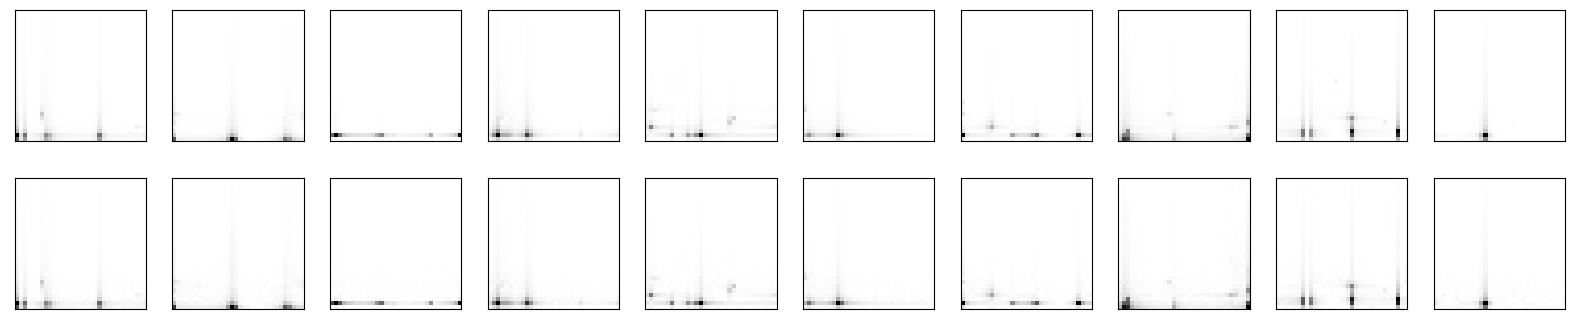

In [8]:
# Display the original and reconstructed pseudo-gray plots of the strength of H
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1 )
  x_testplo = abs(x_test[i, 0, :, :]-0.5 + 1j*(x_test[i, 1, :, :]-0.5))
  plt.imshow(np.max(np.max(x_testplo))-x_testplo.T)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.invert_yaxis()
  
  # display reconstructed
  ax = plt.subplot(2, n, i + 1 + n)
  decoded_imgsplo = abs(x_hat[i, 0, :, :]-0.5
                        + 1j*(x_hat[i, 1, :, :]-0.5))
  plt.imshow(np.max(np.max(decoded_imgsplo))-decoded_imgsplo.T)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.invert_yaxis()

plt.show()

# Section 02

In [1]:
# Import necessary modules
import math
import time
import numpy as np
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, BatchNormalization, Reshape, Conv2D, add, LeakyReLU
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard, Callback
tf.compat.v1.reset_default_graph()

In [2]:
# Set image and network params
envir = 'indoor' #'indoor' or 'outdoor'

# Image params
img_height = 32
img_width = 32
img_channels = 2 
img_total = img_height*img_width*img_channels

# Network params
residual_num = 2
encoded_dim = 512  #compress rate=1/4->dim.=512, compress rate=1/16->dim.=128, compress rate=1/32->dim.=64, compress rate=1/64->dim.=32

In [3]:
# Bulid the autoencoder model (CNN model) of CsiNet
def residual_network(x, residual_num, encoded_dim):
  def add_common_layers(y):
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)
    
    return y
  
  def residual_block_decoded(y):
    shortcut = y
    y = Conv2D(8, kernel_size=(3, 3), padding='same', data_format='channels_first')(y)
    y = add_common_layers(y)
    
    y = Conv2D(16, kernel_size=(3, 3), padding='same', data_format='channels_first')(y)
    y = add_common_layers(y)
    
    y = Conv2D(2, kernel_size=(3, 3), padding='same', data_format='channels_first')(y)
    y = BatchNormalization()(y)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y
  
  x = Conv2D(2, (3, 3), padding='same', data_format="channels_first")(x)
  x = add_common_layers(x)
  
  x = Reshape((img_total,))(x)
  encoded = Dense(encoded_dim, activation='linear')(x)
  
  x = Dense(img_total, activation='linear')(encoded)
  x = Reshape((img_channels, img_height, img_width,))(x)
  for i in range(residual_num):
    x = residual_block_decoded(x)
  
  x = Conv2D(2, (3, 3), activation='sigmoid', padding='same', data_format="channels_first")(x)
  
  return x

In [4]:
# Set autoencoder model params and display the network model
image_tensor = Input(shape=(img_channels, img_height, img_width))
network_output = residual_network(image_tensor, residual_num, encoded_dim)
autoencoder = Model(inputs=[image_tensor], outputs=[network_output])
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 32, 32)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 2, 32, 32)    38          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2, 32, 32)   128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 2, 32, 32)    0           ['batch_normalization[0][0]']

2022-09-08 15:03:41.544518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:03:41.563541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:03:41.563706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-08 15:03:41.564453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
# Load dataset
if envir == 'indoor':
  mat = sio.loadmat('files_06_channel/data/DATA_Htrainin.mat') 
  x_train = mat['HT'] # array
  mat = sio.loadmat('files_06_channel/data/DATA_Hvalin.mat')
  x_val = mat['HT'] # array
  mat = sio.loadmat('files_06_channel/data/DATA_Htestin.mat')
  x_test = mat['HT'] # array

elif envir == 'outdoor':
  mat = sio.loadmat('files_06_channel/data/DATA_Htrainout.mat') 
  x_train = mat['HT'] # array
  mat = sio.loadmat('files_06_channel/data/DATA_Hvalout.mat')
  x_val = mat['HT'] # array
  mat = sio.loadmat('files_06_channel/data/DATA_Htestout.mat')
  x_test = mat['HT'] # array

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train = np.reshape(x_train, (len(x_train), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
x_val = np.reshape(x_val, (len(x_val), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format

In [6]:
# Create a class to save the loss history of the model
class LossHistory(Callback):
  def on_train_begin(self, logs={}):
    self.losses_train = []
    self.losses_val = []
  
  def on_batch_end(self, batch, logs={}):
    self.losses_train.append(logs.get('loss'))    
    
  def on_epoch_end(self, epoch, logs={}):
    self.losses_val.append(logs.get('val_loss'))

history = LossHistory()
file = 'CsiNet_'+(envir)+'_dim'+str(encoded_dim)+time.strftime('_%m_%d')
path = 'files_06_channel/result/TensorBoard_%s' %file

In [7]:
# Train the model with the specified params and save the train loss and val loss in a csv file
autoencoder.fit(x_train, x_train,
                epochs=1000,
                batch_size=200,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[history,
                           TensorBoard(log_dir = path)])

filename = 'files_06_channel/result/trainloss_%s.csv'%file
loss_history = np.array(history.losses_train)
np.savetxt(filename, loss_history, delimiter=",")

filename = 'files_06_channel/result/valloss_%s.csv'%file
loss_history = np.array(history.losses_val)
np.savetxt(filename, loss_history, delimiter=",")

Epoch 1/1000


2022-09-08 15:04:27.943380: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


500/500 [==============================] - 10s 14ms/step - loss: 0.0011 - val_loss: 4.4028e-04
Epoch 2/1000
500/500 [==============================] - 6s 13ms/step - loss: 3.9288e-04 - val_loss: 3.7147e-04
Epoch 3/1000
500/500 [==============================] - 7s 13ms/step - loss: 3.4348e-04 - val_loss: 3.2810e-04
Epoch 4/1000
500/500 [==============================] - 7s 13ms/step - loss: 3.0030e-04 - val_loss: 2.8851e-04
Epoch 5/1000
500/500 [==============================] - 7s 13ms/step - loss: 2.5925e-04 - val_loss: 2.4718e-04
Epoch 6/1000
500/500 [==============================] - 7s 13ms/step - loss: 2.2471e-04 - val_loss: 2.0936e-04
Epoch 7/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.9814e-04 - val_loss: 1.9086e-04
Epoch 8/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.7697e-04 - val_loss: 1.7812e-04
Epoch 9/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.5996e-04 - val_loss: 1.6613e-04
Epoch 10/1000
500

500/500 [==============================] - 7s 13ms/step - loss: 5.1420e-05 - val_loss: 5.0841e-05
Epoch 73/1000
500/500 [==============================] - 7s 13ms/step - loss: 4.8472e-05 - val_loss: 4.7842e-05
Epoch 74/1000
500/500 [==============================] - 7s 13ms/step - loss: 4.6133e-05 - val_loss: 4.6827e-05
Epoch 75/1000
500/500 [==============================] - 7s 13ms/step - loss: 4.4236e-05 - val_loss: 4.4616e-05
Epoch 76/1000
500/500 [==============================] - 7s 13ms/step - loss: 4.2809e-05 - val_loss: 4.1620e-05
Epoch 77/1000
500/500 [==============================] - 7s 13ms/step - loss: 4.1017e-05 - val_loss: 4.0179e-05
Epoch 78/1000
500/500 [==============================] - 7s 13ms/step - loss: 3.9792e-05 - val_loss: 3.7821e-05
Epoch 79/1000
500/500 [==============================] - 7s 13ms/step - loss: 3.8409e-05 - val_loss: 4.0822e-05
Epoch 80/1000
500/500 [==============================] - 7s 13ms/step - loss: 3.7289e-05 - val_loss: 3.6540e-05
Epoch 

Epoch 145/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.5859e-05 - val_loss: 1.5468e-05
Epoch 146/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.5698e-05 - val_loss: 1.4914e-05
Epoch 147/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.5668e-05 - val_loss: 1.7928e-05
Epoch 148/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.5469e-05 - val_loss: 1.6114e-05
Epoch 149/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.5364e-05 - val_loss: 1.5986e-05
Epoch 150/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.5372e-05 - val_loss: 1.5955e-05
Epoch 151/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.5170e-05 - val_loss: 1.4317e-05
Epoch 152/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.5019e-05 - val_loss: 1.6056e-05
Epoch 153/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.5148e-05 - val_

500/500 [==============================] - 7s 13ms/step - loss: 1.1643e-05 - val_loss: 1.1550e-05
Epoch 218/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.1554e-05 - val_loss: 1.1944e-05
Epoch 219/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.1572e-05 - val_loss: 1.2942e-05
Epoch 220/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.1560e-05 - val_loss: 1.2084e-05
Epoch 221/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.1435e-05 - val_loss: 1.2001e-05
Epoch 222/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.1473e-05 - val_loss: 1.1369e-05
Epoch 223/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.1328e-05 - val_loss: 1.2286e-05
Epoch 224/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.1431e-05 - val_loss: 1.1928e-05
Epoch 225/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.1381e-05 - val_loss: 1.2314e-0

500/500 [==============================] - 7s 13ms/step - loss: 1.0079e-05 - val_loss: 1.0166e-05
Epoch 290/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.0119e-05 - val_loss: 9.7438e-06
Epoch 291/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.0010e-05 - val_loss: 1.0055e-05
Epoch 292/1000
500/500 [==============================] - 7s 13ms/step - loss: 9.9889e-06 - val_loss: 1.0452e-05
Epoch 293/1000
500/500 [==============================] - 7s 13ms/step - loss: 9.9092e-06 - val_loss: 1.1138e-05
Epoch 294/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.0021e-05 - val_loss: 1.0085e-05
Epoch 295/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.0029e-05 - val_loss: 1.0336e-05
Epoch 296/1000
500/500 [==============================] - 7s 13ms/step - loss: 9.9172e-06 - val_loss: 1.0100e-05
Epoch 297/1000
500/500 [==============================] - 7s 13ms/step - loss: 9.9174e-06 - val_loss: 1.1893e-0

500/500 [==============================] - 7s 13ms/step - loss: 9.1118e-06 - val_loss: 9.6884e-06
Epoch 362/1000
500/500 [==============================] - 7s 13ms/step - loss: 9.0206e-06 - val_loss: 9.1259e-06
Epoch 363/1000
500/500 [==============================] - 7s 13ms/step - loss: 9.0886e-06 - val_loss: 1.0669e-05
Epoch 364/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.9350e-06 - val_loss: 9.7983e-06
Epoch 365/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.9971e-06 - val_loss: 1.0166e-05
Epoch 366/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.9853e-06 - val_loss: 9.2840e-06
Epoch 367/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.9863e-06 - val_loss: 9.6326e-06
Epoch 368/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.9496e-06 - val_loss: 9.2998e-06
Epoch 369/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.9170e-06 - val_loss: 9.1130e-0

500/500 [==============================] - 7s 13ms/step - loss: 8.3320e-06 - val_loss: 8.2485e-06
Epoch 434/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.2742e-06 - val_loss: 8.7824e-06
Epoch 435/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.2566e-06 - val_loss: 9.2687e-06
Epoch 436/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.3008e-06 - val_loss: 9.2204e-06
Epoch 437/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.2813e-06 - val_loss: 8.6802e-06
Epoch 438/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.3180e-06 - val_loss: 9.2281e-06
Epoch 439/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.2934e-06 - val_loss: 1.0286e-05
Epoch 440/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.2609e-06 - val_loss: 8.2805e-06
Epoch 441/1000
500/500 [==============================] - 7s 13ms/step - loss: 8.1786e-06 - val_loss: 8.3108e-0

500/500 [==============================] - 7s 13ms/step - loss: 7.7565e-06 - val_loss: 9.3367e-06
Epoch 506/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.7720e-06 - val_loss: 9.1768e-06
Epoch 507/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.6663e-06 - val_loss: 8.7801e-06
Epoch 508/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.6804e-06 - val_loss: 8.8128e-06
Epoch 509/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.6954e-06 - val_loss: 7.8360e-06
Epoch 510/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.7303e-06 - val_loss: 7.9489e-06
Epoch 511/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.6265e-06 - val_loss: 8.1507e-06
Epoch 512/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.7016e-06 - val_loss: 7.6909e-06
Epoch 513/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.6731e-06 - val_loss: 8.4975e-0

500/500 [==============================] - 7s 13ms/step - loss: 7.2270e-06 - val_loss: 8.3133e-06
Epoch 578/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.2657e-06 - val_loss: 7.8284e-06
Epoch 579/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.2500e-06 - val_loss: 7.2623e-06
Epoch 580/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.2291e-06 - val_loss: 7.1954e-06
Epoch 581/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.1755e-06 - val_loss: 7.5821e-06
Epoch 582/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.2485e-06 - val_loss: 7.8706e-06
Epoch 583/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.1751e-06 - val_loss: 7.2468e-06
Epoch 584/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.2229e-06 - val_loss: 7.7001e-06
Epoch 585/1000
500/500 [==============================] - 7s 13ms/step - loss: 7.1903e-06 - val_loss: 7.9373e-0

500/500 [==============================] - 7s 13ms/step - loss: 6.8019e-06 - val_loss: 7.2727e-06
Epoch 650/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.9142e-06 - val_loss: 7.2066e-06
Epoch 651/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.8736e-06 - val_loss: 7.1138e-06
Epoch 652/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.8630e-06 - val_loss: 7.6689e-06
Epoch 653/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.8654e-06 - val_loss: 8.1733e-06
Epoch 654/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.8355e-06 - val_loss: 7.6114e-06
Epoch 655/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.8594e-06 - val_loss: 7.6157e-06
Epoch 656/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.9202e-06 - val_loss: 7.5443e-06
Epoch 657/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.8609e-06 - val_loss: 7.5206e-0

500/500 [==============================] - 7s 13ms/step - loss: 6.6383e-06 - val_loss: 6.7683e-06
Epoch 722/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.5840e-06 - val_loss: 7.1318e-06
Epoch 723/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.6175e-06 - val_loss: 7.7508e-06
Epoch 724/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.5741e-06 - val_loss: 6.7883e-06
Epoch 725/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.6148e-06 - val_loss: 7.7683e-06
Epoch 726/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.5906e-06 - val_loss: 8.5661e-06
Epoch 727/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.6187e-06 - val_loss: 7.0141e-06
Epoch 728/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.5406e-06 - val_loss: 6.6025e-06
Epoch 729/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.5953e-06 - val_loss: 7.1958e-0

500/500 [==============================] - 7s 13ms/step - loss: 6.3482e-06 - val_loss: 7.1144e-06
Epoch 794/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.4424e-06 - val_loss: 6.8403e-06
Epoch 795/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.3595e-06 - val_loss: 7.0196e-06
Epoch 796/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.3030e-06 - val_loss: 7.1557e-06
Epoch 797/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.4350e-06 - val_loss: 6.3440e-06
Epoch 798/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.3635e-06 - val_loss: 6.7205e-06
Epoch 799/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.3399e-06 - val_loss: 6.9217e-06
Epoch 800/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.3740e-06 - val_loss: 6.8672e-06
Epoch 801/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.3427e-06 - val_loss: 7.4660e-0

500/500 [==============================] - 7s 13ms/step - loss: 6.1652e-06 - val_loss: 6.9643e-06
Epoch 866/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.1684e-06 - val_loss: 6.4344e-06
Epoch 867/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.1479e-06 - val_loss: 6.9656e-06
Epoch 868/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.1936e-06 - val_loss: 6.5238e-06
Epoch 869/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.2247e-06 - val_loss: 6.9702e-06
Epoch 870/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.1620e-06 - val_loss: 6.8571e-06
Epoch 871/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.1997e-06 - val_loss: 7.0343e-06
Epoch 872/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.2116e-06 - val_loss: 6.3221e-06
Epoch 873/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.1771e-06 - val_loss: 7.8348e-0

500/500 [==============================] - 7s 13ms/step - loss: 6.0208e-06 - val_loss: 6.6003e-06
Epoch 938/1000
500/500 [==============================] - 7s 13ms/step - loss: 5.9901e-06 - val_loss: 6.4600e-06
Epoch 939/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.0364e-06 - val_loss: 5.7279e-06
Epoch 940/1000
500/500 [==============================] - 7s 13ms/step - loss: 5.9527e-06 - val_loss: 6.7455e-06
Epoch 941/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.0297e-06 - val_loss: 6.8641e-06
Epoch 942/1000
500/500 [==============================] - 7s 13ms/step - loss: 6.0401e-06 - val_loss: 6.6616e-06
Epoch 943/1000
500/500 [==============================] - 7s 13ms/step - loss: 5.9864e-06 - val_loss: 6.5170e-06
Epoch 944/1000
500/500 [==============================] - 7s 13ms/step - loss: 5.9739e-06 - val_loss: 6.3421e-06
Epoch 945/1000
500/500 [==============================] - 7s 13ms/step - loss: 5.9813e-06 - val_loss: 6.4832e-0

In [8]:
# Testing data
tStart = time.time()
x_hat = autoencoder.predict(x_test)
tEnd = time.time()
print ("It cost %f sec" % ((tEnd - tStart)/x_test.shape[0]))

625/625 [==============================] - 2s 3ms/step
It cost 0.000127 sec


In [9]:
# Calcaulating the NMSE and rho
if envir == 'indoor':
  mat = sio.loadmat('files_06_channel/data/DATA_HtestFin_all.mat')
  X_test = mat['HF_all']# array

elif envir == 'outdoor':
  mat = sio.loadmat('files_06_channel/data/DATA_HtestFout_all.mat')
  X_test = mat['HF_all']# array

X_test = np.reshape(X_test, (len(X_test), img_height, 125))
x_test_real = np.reshape(x_test[:, 0, :, :], (len(x_test), -1))
x_test_imag = np.reshape(x_test[:, 1, :, :], (len(x_test), -1))
x_test_C = x_test_real-0.5 + 1j*(x_test_imag-0.5)
x_hat_real = np.reshape(x_hat[:, 0, :, :], (len(x_hat), -1))
x_hat_imag = np.reshape(x_hat[:, 1, :, :], (len(x_hat), -1))
x_hat_C = x_hat_real-0.5 + 1j*(x_hat_imag-0.5)
x_hat_F = np.reshape(x_hat_C, (len(x_hat_C), img_height, img_width))
X_hat = np.fft.fft(np.concatenate((x_hat_F, np.zeros((len(x_hat_C), img_height, 257-img_width))), axis=2), axis=2)
X_hat = X_hat[:, :, 0:125]

n1 = np.sqrt(np.sum(np.conj(X_test)*X_test, axis=1))
n1 = n1.astype('float64')
n2 = np.sqrt(np.sum(np.conj(X_hat)*X_hat, axis=1))
n2 = n2.astype('float64')
aa = abs(np.sum(np.conj(X_test)*X_hat, axis=1))
rho = np.mean(aa/(n1*n2), axis=1)
X_hat = np.reshape(X_hat, (len(X_hat), -1))
X_test = np.reshape(X_test, (len(X_test), -1))
power = np.sum(abs(x_test_C)**2, axis=1)
power_d = np.sum(abs(X_hat)**2, axis=1)
mse = np.sum(abs(x_test_C-x_hat_C)**2, axis=1)

/tmp/ipykernel_11145/1304209954.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  n1 = n1.astype('float64')
/tmp/ipykernel_11145/1304209954.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  n2 = n2.astype('float64')


In [10]:
print("In "+envir+" environment")
print("When dimension is", encoded_dim)
print("NMSE is ", 10*math.log10(np.mean(mse/power)))
print("Correlation is ", np.mean(rho))

filename = "files_06_channel/result/decoded_%s.csv"%file
x_hat1 = np.reshape(x_hat, (len(x_hat), -1))
np.savetxt(filename, x_hat1, delimiter=",")
filename = "files_06_channel/result/rho_%s.csv"%file
np.savetxt(filename, rho, delimiter=",")

In indoor environment
When dimension is 512
NMSE is  -18.631636873522087
Correlation is  0.9902885986924393


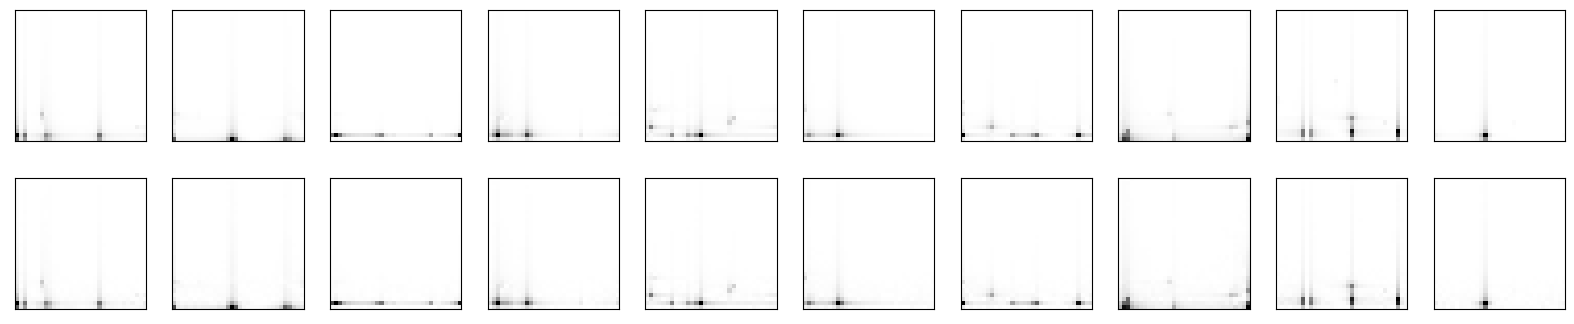

In [11]:
# Display the original and reconstructed pseudo-gray plots of the strength of H
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1 )
  x_testplo = abs(x_test[i, 0, :, :]-0.5 + 1j*(x_test[i, 1, :, :]-0.5))
  plt.imshow(np.max(np.max(x_testplo))-x_testplo.T)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.invert_yaxis()
  
  # display reconstructed
  ax = plt.subplot(2, n, i + 1 + n)
  decoded_imgsplo = abs(x_hat[i, 0, :, :]-0.5
                        + 1j*(x_hat[i, 1, :, :]-0.5))
  plt.imshow(np.max(np.max(decoded_imgsplo))-decoded_imgsplo.T)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.invert_yaxis()

plt.show()

In [12]:
# Save the model and the weights of the autoencoder
model_json = autoencoder.to_json()
outfile = "files_06_channel/result/model_%s.json"%file
with open(outfile, "w") as json_file:
  json_file.write(model_json)
outfile = "files_06_channel/result/model_%s.h5"%file
autoencoder.save_weights(outfile)